<a href="https://colab.research.google.com/github/ibenatar-96/statistical-rethinking-numpyro/blob/main/chapter_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q numpyro arviz daft networkx
!git clone https://github.com/fehiepsi/rethinking-numpyro.git

fatal: destination path 'rethinking-numpyro' already exists and is not an empty directory.


In [ ]:
import collections
import itertools
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import jax.numpy as jnp
from jax import lax, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

In [ ]:
# Code 6.2

N = 100  # number of individuals
with numpyro.handlers.seed(rng_seed=909):
    # sim total height of each
    height = numpyro.sample("height", dist.Normal(10, 2).expand([N]))
    # leg as proportion of height
    leg_prop = numpyro.sample("prop", dist.Uniform(0.4, 0.5).expand([N]))
    # sim left leg as proportion + error
    leg_left = leg_prop * height + numpyro.sample(
        "left_error", dist.Normal(0, 0.02).expand([N])
    )
    # sim right leg as proportion + error
    leg_right = leg_prop * height + numpyro.sample(
        "right_error", dist.Normal(0, 0.02).expand([N])
    )
    # combine into data frame
    d = pd.DataFrame({"height": height, "leg_left": leg_left, "leg_right": leg_right})
d.head()

,height,leg_left,leg_right
0,12.188368,5.964153,5.986165
1,7.967189,3.202669,3.210824
2,13.263365,5.334468,5.292787
3,10.657822,4.684047,4.667180
4,8.223664,4.051148,4.060783


In [ ]:
# Code 6.3

# the model: height = a + (bl * leg_left) + (br * leg_right) + error

def model(leg_left, leg_right, height):
    # Sample the intercept from a normal distribution with mean 10 and standard deviation 100
    a = numpyro.sample("a", dist.Normal(10, 100))

    # Sample the coefficients for left leg length and right leg length from normal distributions
    bl = numpyro.sample("bl", dist.Normal(2, 10))
    br = numpyro.sample("br", dist.Normal(2, 10))

    # bl: This is the coefficient for the left leg length. It quantifies how much the height is expected to increase for each unit increase in the left leg length, all else being equal.
    # br: This is the coefficient for the right leg length. It quantifies how much the height is expected to increase for each unit increase in the right leg length, all else being equal.

    # Sample the standard deviation for the heights from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the mean height using the linear combination of intercept and coefficients
    mu = a + bl * leg_left + br * leg_right

    # Define the likelihood of the observed heights given the mu and sigma
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

# Create an AutoLaplaceApproximation object for the model
m6_1 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(
    model,
    m6_1,
    optim.Adam(0.1),
    Trace_ELBO(),
    leg_left=d.leg_left.values,
    leg_right=d.leg_right.values,
    height=d.height.values,
)

# Run SVI for 2000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 2000)

# Extract the parameters from the SVI result
p6_1 = svi_result.params

# Sample from the posterior distribution using the fitted parameters
post = m6_1.sample_posterior(random.PRNGKey(1), p6_1, sample_shape=(1000,))

# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)

100%|██████████| 2000/2000 [00:01<00:00, 1685.32it/s, init loss: 62894.3750, avg. loss [1901-2000]: 114.1039]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.81      0.34      0.80      0.27      1.31   1049.96      1.00
        bl      2.61      2.28      2.63     -1.06      6.26    813.12      1.00
        br     -0.59      2.28     -0.60     -4.41      2.96    805.69      1.00
     sigma      0.67      0.05      0.67      0.60      0.74    968.52      1.00



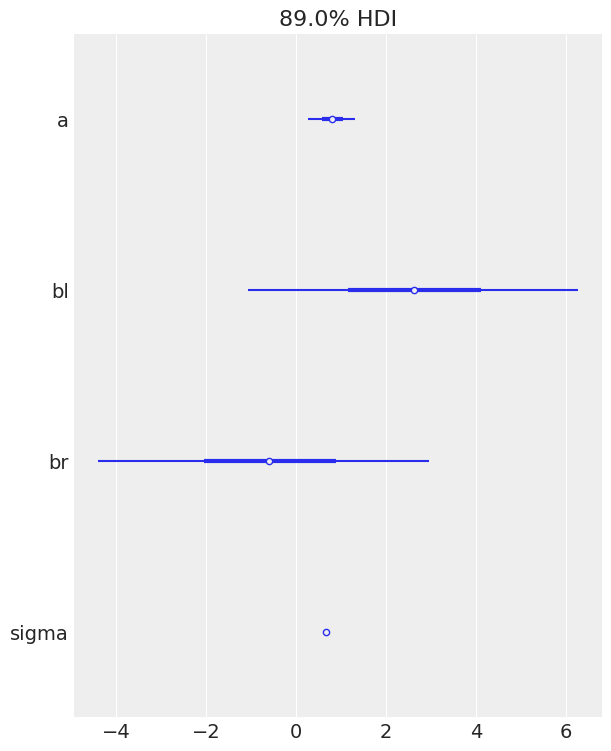

In [ ]:
az.plot_forest(post, hdi_prob=0.89)
plt.show()

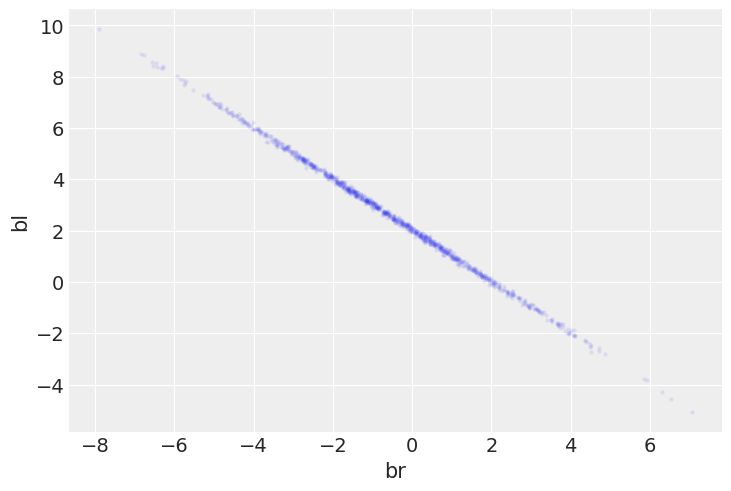

In [ ]:
# Code 6.5

post = m6_1.sample_posterior(random.PRNGKey(1), p6_1, sample_shape=(1000,))
az.plot_pair(post, var_names=["br", "bl"], scatter_kwargs={"alpha": 0.1})
plt.show()

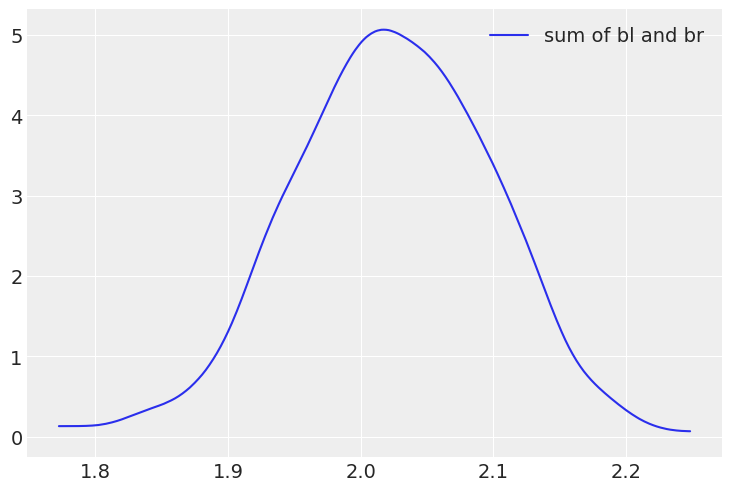

In [ ]:
sum_blbr = post["bl"] + post["br"]
az.plot_kde(sum_blbr, label="sum of bl and br")
plt.show()

In [ ]:
def model(leg_left, height):
    # Sample the intercept from a normal distribution with mean 10 and standard deviation 100
    a = numpyro.sample("a", dist.Normal(10, 100))

    # Sample the coefficient for left leg length from a normal distribution with mean 2 and standard deviation 10
    bl = numpyro.sample("bl", dist.Normal(2, 10))

    # Sample the standard deviation for the heights from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the mean height using the linear combination of intercept and coefficient
    mu = a + bl * leg_left

    # Define the likelihood of the observed heights given the mu and sigma
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

# Create an AutoLaplaceApproximation object for the model
m6_2 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(
    model,
    m6_2,
    optim.Adam(1),
    Trace_ELBO(),
    leg_left=d.leg_left.values,
    height=d.height.values,
)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p6_2 = svi_result.params

# Sample from the posterior distribution using the fitted parameters
post = m6_2.sample_posterior(random.PRNGKey(1), p6_2, sample_shape=(1000,))

# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:00<00:00, 1120.65it/s, init loss: 2486.2402, avg. loss [951-1000]: 110.6717]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.83      0.35      0.84      0.25      1.35    931.50      1.00
        bl      2.02      0.08      2.02      1.91      2.15    940.42      1.00
     sigma      0.67      0.05      0.67      0.60      0.75    949.09      1.00



In [ ]:
milk = pd.read_csv("rethinking-numpyro/data/milk.csv", sep=";")
d = milk
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["F"] = d["perc.fat"].pipe(lambda x: (x - x.mean()) / x.std())
d["L"] = d["perc.lactose"].pipe(lambda x: (x - x.mean()) / x.std())
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


We are interested in percent fat (perc.fat) and percent lactose (perc.lact) variables. We'll use these to model the total energy content, kcal.per.g

In [ ]:
# Code 6.9

# Define model for kcal.per.g regressed on perc.fat
def model(F, K):
    # Sample intercept from a normal distribution with mean 0 and standard deviation 0.2
    a = numpyro.sample("a", dist.Normal(0, 0.2))

    # Sample coefficient for perc.fat from a normal distribution with mean 0 and standard deviation 0.5
    bF = numpyro.sample("bF", dist.Normal(0, 0.5))

    # Sample standard deviation for the kcal values from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the mean kcal value using the linear combination of intercept and coefficient for perc.fat
    mu = a + bF * F

    # Define the likelihood of the observed standardized kcal values given the mu and sigma
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

# Create an AutoLaplaceApproximation object for the model
m6_3 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(model, m6_3, optim.Adam(1), Trace_ELBO(), F=d.F.values, K=d.K.values)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p6_3 = svi_result.params

# Define model for kcal.per.g regressed on perc.lactose
def model(L, K):
    # Sample intercept from a normal distribution with mean 0 and standard deviation 0.2
    a = numpyro.sample("a", dist.Normal(0, 0.2))

    # Sample coefficient for perc.lactose from a normal distribution with mean 0 and standard deviation 0.5
    bL = numpyro.sample("bL", dist.Normal(0, 0.5))

    # Sample standard deviation for the kcal values from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the mean kcal value using the linear combination of intercept and coefficient for perc.lactose
    mu = a + bL * L

    # Define the likelihood of the observed standardized kcal values given the mu and sigma
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

# Create an AutoLaplaceApproximation object for the model
m6_4 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(model, m6_4, optim.Adam(1), Trace_ELBO(), L=d.L.values, K=d.K.values)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p6_4 = svi_result.params

# Sample from the posterior distribution using the fitted parameters for the first model
post = m6_3.sample_posterior(random.PRNGKey(1), p6_3, sample_shape=(1000,))
# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)

# Sample from the posterior distribution using the fitted parameters for the second model
post = m6_4.sample_posterior(random.PRNGKey(1), p6_4, sample_shape=(1000,))
# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)


100%|██████████| 1000/1000 [00:00<00:00, 1053.63it/s, init loss: 1449.6162, avg. loss [951-1000]: 16.0152]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.01      0.08      0.01     -0.13      0.12    931.50      1.00
        bF      0.86      0.09      0.86      0.73      1.01   1111.41      1.00
     sigma      0.46      0.06      0.46      0.37      0.57    940.36      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.07      0.07      0.07     -0.05      0.17    931.50      1.00
        bL     -0.90      0.07     -0.90     -1.01     -0.77   1111.59      1.00
     sigma      0.39      0.05      0.39      0.30      0.48    956.03      1.00



Now we will see what happens when we use both predictor variables in the same regression model (multivariate regression)

In [ ]:
# Code 6.10

def model(F, L, K):
    # Sample intercept from a normal distribution with mean 0 and standard deviation 0.2
    a = numpyro.sample("a", dist.Normal(0, 0.2))

    # Sample coefficient for perc.fat from a normal distribution with mean 0 and standard deviation 0.5
    bF = numpyro.sample("bF", dist.Normal(0, 0.5))

    # Sample coefficient for perc.lactose from a normal distribution with mean 0 and standard deviation 0.5
    bL = numpyro.sample("bL", dist.Normal(0, 0.5))

    # Sample standard deviation for the kcal values from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the mean kcal value using the linear combination of intercept and coefficients
    mu = a + bF * F + bL * L

    # Define the likelihood of the observed standardized kcal values given the mu and sigma
    numpyro.sample("K", dist.Normal(mu, sigma), obs=K)

# Create an AutoLaplaceApproximation object for the model
m6_5 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(
    model,
    m6_5,
    optim.Adam(1),
    Trace_ELBO(),
    F=d.F.values,
    L=d.L.values,
    K=d.K.values
)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p6_5 = svi_result.params

# Sample from the posterior distribution using the fitted parameters
post = m6_5.sample_posterior(random.PRNGKey(1), p6_5, sample_shape=(1000,))

# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)


100%|██████████| 1000/1000 [00:01<00:00, 872.52it/s, init loss: 1360.7052, avg. loss [951-1000]: 15.2600]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.01      0.07     -0.01     -0.11      0.09   1049.96      1.00
        bF      0.25      0.19      0.25     -0.05      0.56    822.78      1.00
        bL     -0.67      0.19     -0.67     -0.99     -0.37    873.85      1.00
     sigma      0.39      0.05      0.38      0.31      0.46    968.65      1.00



Now the posterior means of both bF and bL are closer to zero. And the standard deviations for both parameters are twice as large in the bivariate models.

This happens because the variables perc.fat and perc.lactose contain much of the same information

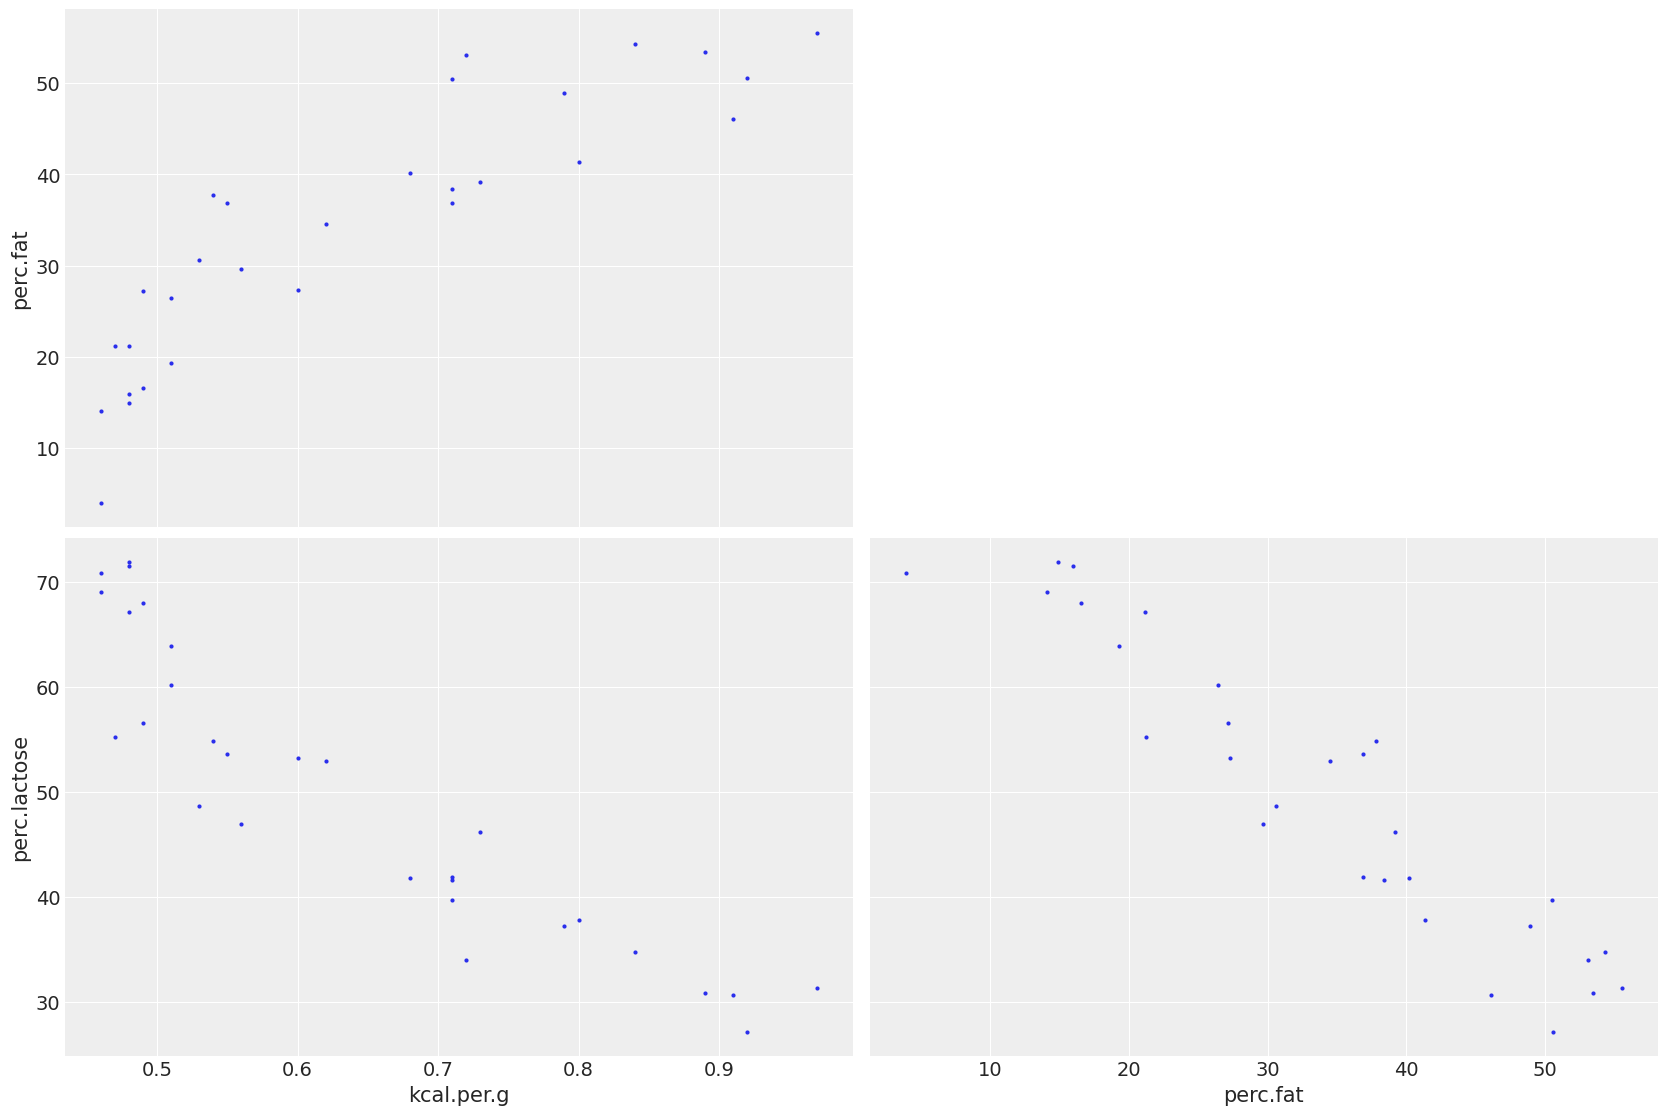

In [ ]:
az.plot_pair(d[["kcal.per.g", "perc.fat", "perc.lactose"]].to_dict("list"))
plt.show()

In [ ]:
# Seed the random number generator for reproducibility
with numpyro.handlers.seed(rng_seed=71):
    # Number of plants
    N = 100

    # Simulate initial heights of plants
    h0 = numpyro.sample("h0", dist.Normal(10, 2).expand([N]))

    # Assign treatments (0 or 1) to the plants
    treatment = jnp.repeat(jnp.arange(2), repeats=N // 2)

    # Simulate fungus presence based on treatment
    # For treatment 0: probability of fungus = 0.5
    # For treatment 1: probability of fungus = 0.1
    fungus = numpyro.sample(
        "fungus", dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4))
    )

    # Simulate the final heights after applying treatment and fungus effect
    # For plants with fungus, growth is reduced by 3 units
    h1 = h0 + numpyro.sample("diff", dist.Normal(5 - 3 * fungus))

    # Compose a clean data frame with the simulated data
    d = pd.DataFrame({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})

# Print summary of the data frame with 89% credible intervals
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)



                 mean       std    median      5.5%     94.5%     n_eff     r_hat
     fungus      0.31      0.46      0.00      0.00      1.00     18.52      1.17
         h0      9.73      1.95      9.63      7.05     13.33     80.22      0.99
         h1     13.72      2.47     13.60     10.73     18.38     43.44      1.08
  treatment      0.50      0.50      0.50      0.00      1.00      2.64       inf



In [ ]:
# Sample from a LogNormal distribution with mean 0 and standard deviation 0.25
# Generate 10,000 samples using the specified random key
# Log-Normal is always positive. and sim_p is supposed to represent h1_i/h0_i
sim_p = dist.LogNormal(0, 0.25).sample(random.PRNGKey(0), (int(1e4),))

# Print summary statistics of the sampled data with 89% credible intervals
print_summary({"sim_p": sim_p}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     sim_p      1.04      0.27      1.00      0.63      1.44   9936.32      1.00



In [ ]:
# Code 6.15

def model(h0, h1):
    # Sample the proportion from a log-normal distribution with mean 0 and standard deviation 0.25
    p = numpyro.sample("p", dist.LogNormal(0, 0.25))

    # Sample the standard deviation for the heights from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the mean height h1 using the proportion and initial height h0
    mu = h0 * p

    # Define the likelihood of the observed heights given the mu and sigma
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

# Create an AutoLaplaceApproximation object for the model
m6_6 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(model, m6_6, optim.Adam(1), Trace_ELBO(), h0=d.h0.values, h1=d.h1.values)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p6_6 = svi_result.params

# Sample from the posterior distribution using the fitted parameters
post = m6_6.sample_posterior(random.PRNGKey(1), p6_6, sample_shape=(1000,))

# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)

100%|██████████| 1000/1000 [00:01<00:00, 606.33it/s, init loss: 279.8950, avg. loss [951-1000]: 204.3793]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      1.39      0.02      1.39      1.36      1.42    994.30      1.00
     sigma      1.84      0.13      1.84      1.65      2.06   1011.70      1.00



In [ ]:
# Code 6.16

def model(treatment, fungus, h0, h1):
    # Sample the intercept from a log-normal distribution with mean 0 and standard deviation 0.2
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))

    # Sample the coefficient for treatment from a normal distribution with mean 0 and standard deviation 0.5
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))

    # Sample the coefficient for fungus from a normal distribution with mean 0 and standard deviation 0.5
    bf = numpyro.sample("bf", dist.Normal(0, 0.5))

    # Sample the standard deviation for the heights from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the proportion affected by treatment and fungus
    p = a + bt * treatment + bf * fungus

    # Calculate the mean height h1 using the initial height h0 and the proportion p
    mu = h0 * p

    # Define the likelihood of the observed heights given the mu and sigma
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

# Create an AutoLaplaceApproximation object for the model
m6_7 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(
    model,
    m6_7,
    optim.Adam(0.3),
    Trace_ELBO(),
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p6_7 = svi_result.params

# Sample from the posterior distribution using the fitted parameters
post = m6_7.sample_posterior(random.PRNGKey(1), p6_7, sample_shape=(1000,))

# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)


100%|██████████| 1000/1000 [00:00<00:00, 1856.80it/s, init loss: 151456.4219, avg. loss [951-1000]: 168.2294]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      1.47      0.03      1.47      1.43      1.51   1049.04      1.00
        bf     -0.28      0.03     -0.28     -0.33     -0.23   1111.97      1.00
        bt      0.01      0.03      0.01     -0.03      0.06    932.14      1.00
     sigma      1.39      0.10      1.39      1.21      1.54    975.77      1.00



In [ ]:
def model(treatment, h0, h1):
    # Sample the intercept from a log-normal distribution with mean 0 and standard deviation 0.2
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))

    # Sample the coefficient for treatment from a normal distribution with mean 0 and standard deviation 0.5
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))

    # Sample the standard deviation for the heights from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the proportion affected by treatment
    p = a + bt * treatment

    # Calculate the mean height h1 using the initial height h0 and the proportion p
    mu = h0 * p

    # Define the likelihood of the observed heights given the mu and sigma
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

# Create an AutoLaplaceApproximation object for the model
m6_8 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(
    model,
    m6_8,
    optim.Adam(1),
    Trace_ELBO(),
    treatment=d.treatment.values,
    h0=d.h0.values,
    h1=d.h1.values,
)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p6_8 = svi_result.params

# Sample from the posterior distribution using the fitted parameters
post = m6_8.sample_posterior(random.PRNGKey(1), p6_8, sample_shape=(1000,))

# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)


100%|██████████| 1000/1000 [00:01<00:00, 874.20it/s, init loss: 87469.1172, avg. loss [951-1000]: 198.4735]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      1.33      0.02      1.33      1.29      1.37    930.82      1.00
        bt      0.13      0.04      0.12      0.08      0.19    880.02      1.00
     sigma      1.73      0.12      1.73      1.55      1.94    948.82      1.00



In [ ]:
with numpyro.handlers.seed(rng_seed=71):
    N = 1000  # Number of samples

    # Sample initial heights h0 from a normal distribution with mean 10 and standard deviation 2
    h0 = numpyro.sample("h0", dist.Normal(10, 2).expand([N]))

    # Create a treatment array with two groups (0 and 1), each repeated N/2 times
    treatment = jnp.repeat(jnp.arange(2), repeats=N // 2)

    # Sample M (a binary variable) from a Bernoulli distribution with probability 0.5
    M = numpyro.sample("M", dist.Bernoulli(probs=0.5).expand([N]))

    # Sample fungus (a binary variable) from a Binomial distribution with a probability
    # that decreases by 0.4 for the treatment group (treatment == 1)
    fungus = numpyro.sample(
        "fungus", dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4))
    )

    # Calculate final heights h1 by adding a sampled difference to h0.
    # The difference depends on M and is sampled from a normal distribution with mean 5 + 3 * M
    h1 = h0 + numpyro.sample("diff", dist.Normal(5 + 3 * M))

    # Create a DataFrame with the generated data
    d2 = pd.DataFrame({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})
d2

,h0,h1,treatment,fungus
0,13.061360,19.977493,0,0
1,8.164921,13.987118,0,1
2,11.924334,19.458199,0,0
3,10.908574,20.459034,0,0
4,6.734402,13.814970,0,1
...,...,...,...,...
995,9.860641,17.344654,1,0
996,10.947635,18.473625,1,0
997,13.059104,18.473370,1,0
998,9.549099,15.364206,1,0


In [ ]:
def sim_happiness(seed=1977, N_years=1000, max_age=65, N_births=20, aom=18):
    # Simulate ages for individuals over the years
    A = jnp.repeat(jnp.arange(1, N_years + 1), N_births)

    # Simulate happiness trait for individuals, never changes
    H = jnp.repeat(jnp.linspace(-2, 2, N_births)[None, :], N_years, 0).reshape(-1)

    # Initialize marital status as not married (0)
    M = jnp.zeros(N_years * N_births, dtype=jnp.int32)

    # Function to update marital status for each year
    def update_M(i, M):
        # For each person over the age of aom, chance to get married based on happiness
        married = dist.Bernoulli(logits=(H - 4)).sample(random.PRNGKey(seed + i))
        return jnp.where((A >= i) & (M == 0), married, M)

    # Loop over ages from aom to max_age to update marital status
    M = lax.fori_loop(aom, max_age + 1, update_M, M)

    # Apply mortality: remove individuals older than max_age
    deaths = A > max_age
    A = A[~deaths]
    H = H[~deaths]
    M = M[~deaths]

    # Create a DataFrame with the resulting data
    d = pd.DataFrame({"age": A, "married": M, "happiness": H})
    return d

# Simulate the happiness dataset
d = sim_happiness(seed=1977, N_years=1000)

# Print a summary of the simulated data with an 89% credible interval
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)
d


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
        age     33.00     18.77     33.00      1.00     58.00      2.51      2.64
  happiness      0.00      1.21      0.00     -2.00      1.58    338.78      1.00
    married      0.28      0.45      0.00      0.00      1.00     48.04      1.18



,age,married,happiness
0,1,0,-2.000000
1,1,0,-1.789474
2,1,0,-1.578947
3,1,0,-1.368421
4,1,0,-1.157895
...,...,...,...
1295,65,1,1.157895
1296,65,1,1.368421
1297,65,1,1.578947
1298,65,1,1.789474


In [ ]:
d2 = d[d.age > 17].copy()  # only adults
d2["A"] = (d2.age - 18) / (65 - 18)

In [ ]:
# Add a 'mid' column to the dataframe d2, which is the same as the 'married' column
d2["mid"] = d2.married

def model(mid, A, happiness):
    # Sample the intercept 'a' for each marriage status from a normal distribution with mean 0 and standard deviation 1
    a = numpyro.sample("a", dist.Normal(0, 1).expand([len(set(mid))]))

    # Sample the coefficient for age 'bA' from a normal distribution with mean 0 and standard deviation 2
    bA = numpyro.sample("bA", dist.Normal(0, 2))

    # Sample the standard deviation for happiness from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the mean happiness 'mu' as a function of marriage status and age
    mu = a[mid] + bA * A

    # Define the likelihood of the observed happiness given the mu and sigma
    numpyro.sample("happiness", dist.Normal(mu, sigma), obs=happiness)

# Create an AutoLaplaceApproximation object for the model
m6_9 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(
    model,
    m6_9,
    optim.Adam(1),
    Trace_ELBO(),
    mid=d2.mid.values,
    A=d2.A.values,
    happiness=d2.happiness.values,
)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p6_9 = svi_result.params

# Sample from the posterior distribution using the fitted parameters
post = m6_9.sample_posterior(random.PRNGKey(1), p6_9, sample_shape=(1000,))

# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)


100%|██████████| 1000/1000 [00:00<00:00, 1308.44it/s, init loss: 12964.1768, avg. loss [951-1000]: 1383.4535]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.20      0.06     -0.20     -0.30     -0.10   1049.96      1.00
      a[1]      1.23      0.09      1.23      1.09      1.37    898.97      1.00
        bA     -0.69      0.11     -0.69     -0.88     -0.53   1126.51      1.00
     sigma      1.02      0.02      1.02      0.98      1.05    966.00      1.00



In [ ]:
def model(A, happiness):
    # Sample the intercept 'a' from a normal distribution with mean 0 and standard deviation 1
    a = numpyro.sample("a", dist.Normal(0, 1))

    # Sample the coefficient for age 'bA' from a normal distribution with mean 0 and standard deviation 2
    bA = numpyro.sample("bA", dist.Normal(0, 2))

    # Sample the standard deviation for happiness from an exponential distribution with rate 1
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Calculate the mean happiness 'mu' as a function of age
    mu = a + bA * A

    # Define the likelihood of the observed happiness given the mu and sigma
    numpyro.sample("happiness", dist.Normal(mu, sigma), obs=happiness)

# Create an AutoLaplaceApproximation object for the model
m6_10 = AutoLaplaceApproximation(model)

# Set up Stochastic Variational Inference (SVI) with the model, approximation, optimizer, and loss function
svi = SVI(
    model,
    m6_10,
    optim.Adam(1),
    Trace_ELBO(),
    A=d2.A.values,
    happiness=d2.happiness.values,
)

# Run SVI for 1000 iterations to fit the model and get the result
svi_result = svi.run(random.PRNGKey(0), 1000)

# Extract the parameters from the SVI result
p6_10 = svi_result.params

# Sample from the posterior distribution using the fitted parameters
post = m6_10.sample_posterior(random.PRNGKey(1), p6_10, sample_shape=(1000,))

# Print a summary of the posterior samples with an 89% credible interval
print_summary(post, 0.89, False)


100%|██████████| 1000/1000 [00:01<00:00, 591.48it/s, init loss: 19561.3926, avg. loss [951-1000]: 1551.8597]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.01      0.08      0.01     -0.12      0.12    931.50      1.00
        bA     -0.01      0.13     -0.01     -0.22      0.21    940.88      1.00
     sigma      1.21      0.03      1.21      1.17      1.26    949.78      1.00

